In [1]:
# importing libraries and data

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


training_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
testing_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [2]:
# checking for nulls

training = training_data.isnull().sum().sum()
print(f"Nulls in training: {training}")

validation = testing_data.isnull().sum().sum()
print(f"Nulls in validation: {validation}")

Nulls in training: 0
Nulls in validation: 0


In [3]:
# separate x and y for test and train data

train_X = training_data.iloc[: , 1:]

train_Y = training_data.iloc[:,0]

test_X = testing_data

train_X.shape, train_Y.shape


((42000, 784), (42000,))

In [4]:
# data normalization

train_X = train_X / 255.0
test_X = test_X / 255.0

In [5]:
# reshape data

train_X = train_X.values.reshape(-1, 28, 28, 1)
test_X = test_X.values.reshape(-1, 28, 28, 1)

train_X.shape, test_X.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [6]:
# split data into train and test slices

train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.1)

train_X.shape, val_X.shape, train_Y.shape, val_Y.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800,), (4200,))

In [7]:
# one hot encoding

train_Y = keras.utils.to_categorical(train_Y, num_classes=10)
val_Y = keras.utils.to_categorical(val_Y, num_classes=10)

train_Y.shape, val_Y.shape

((37800, 10), (4200, 10))

In [8]:
# defining plotting functions

def show_train_number(idx):
  plt.imshow(train_X[idx].reshape(28, 28))  # (rows, columns)
  plt.title(f"Digit: {np.where(train_Y[idx] == np.amax(train_Y[idx]))[0]}")
  plt.show() 

def show_val_number(idx):
  plt.imshow(val_X[idx].reshape(28, 28))  # (rows, columns)
  plt.title(f"Digit: {np.where(val_Y[idx] == np.amax(val_Y[idx]))[0]}")
  plt.show() 

def show_testing_data(idx):
  plt.imshow(testing_data[idx].reshape(28, 28))  # (rows, columns)
  plt.show()

In [9]:
# data augmentation

datagen = ImageDataGenerator(zoom_range = 0.1,
                             height_shift_range = 0.1,
                             width_shift_range = 0.1,
                             rotation_range = 10)
    
datagen.fit(train_X)

In [10]:
# model initialization

def convolutional_model():
    input_img = tf.keras.Input(shape=(28,28,1))
    Z1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5), strides=(1, 1), padding='same')(input_img)
    Z1 = tf.keras.layers.BatchNormalization(axis = 3) (Z1, training = True)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same')(A1)
    DO1 = tf.keras.layers.Dropout(0.1)(P1)
    
    Z2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides=(1, 1), padding='same')(DO1)
    Z2 = tf.keras.layers.BatchNormalization(axis = 3) (Z2, training = True)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same')(A2)
    DO2 = tf.keras.layers.Dropout(0.1)(P2)
    
    Z3 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides=(1, 1), padding='same')(DO2)
    Z3 = tf.keras.layers.BatchNormalization(axis = 3) (Z3, training = True)
    A3 = tf.keras.layers.ReLU()(Z3)
    P3 = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2, padding = 'same')(A3)
    DO3 = tf.keras.layers.Dropout(0.1)(P3)
    
    F1 = tf.keras.layers.Flatten()(DO3)
    D1 = tf.keras.layers.Dense(256, activation='relu')(F1)
    DO4 = tf.keras.layers.Dropout(0.1)(D1)
    
    F = tf.keras.layers.Flatten()(DO4)
    
    outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax') (F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [11]:
model = convolutional_model()
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248  

2022-06-28 19:49:39.404686: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# initiate early stopping to prevent overfitting

early_stopping = keras.callbacks.EarlyStopping(
    patience=4,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(datagen.flow(train_X, train_Y),
                         epochs=30,
                         validation_data=(val_X, val_Y),
                         batch_size=128,
                         callbacks=[early_stopping])

2022-06-28 19:49:39.818086: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
1182/1182 [==============================] - 41s 34ms/step - loss: 0.3086 - accuracy: 0.8998 - val_loss: 0.0711 - val_accuracy: 0.9755
Epoch 2/30
1182/1182 [==============================] - 40s 34ms/step - loss: 0.1129 - accuracy: 0.9637 - val_loss: 0.0635 - val_accuracy: 0.9819
Epoch 3/30
1182/1182 [==============================] - 39s 33ms/step - loss: 0.0884 - accuracy: 0.9721 - val_loss: 0.0330 - val_accuracy: 0.9905
Epoch 4/30
1182/1182 [==============================] - 40s 34ms/step - loss: 0.0775 - accuracy: 0.9771 - val_loss: 0.0337 - val_accuracy: 0.9883
Epoch 5/30
1182/1182 [==============================] - 39s 33ms/step - loss: 0.0694 - accuracy: 0.9781 - val_loss: 0.0409 - val_accuracy: 0.9876
Epoch 6/30
1182/1182 [==============================] - 40s 34ms/step - loss: 0.0627 - accuracy: 0.9806 - val_loss: 0.0293 - val_accuracy: 0.9917
Epoch 7/30
1182/1182 [==============================] - 39s 33ms/step - loss: 0.0575 - accuracy: 0.9829 - val_loss: 0.0278 -

Expected digit: [2]
Prediction: [2]


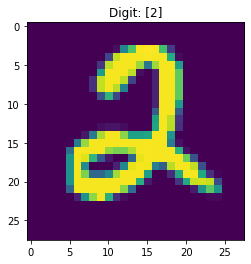

In [13]:
# testing with one element of the dataset

valIdx = 25;

output = model.predict(val_X)[valIdx]

# converting model output into a single value
res = np.where(output == np.amax(output))

# converting hotmap array into a single value
expected = np.where(val_Y[valIdx] == np.amax(val_Y[valIdx]))

print(f"Expected digit: {expected[0]}")
print(f"Prediction: {res[0]}")
show_val_number(valIdx)

[1 0 0 ... 4 0 0]
[1 0 0 ... 4 0 0]


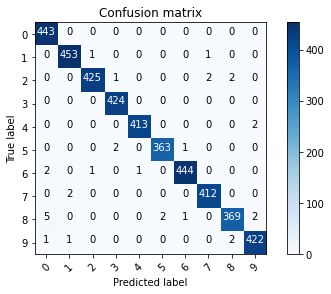

In [14]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(val_X)

# Convert predictions classes to numbers
Y_pred_classes = np.argmax(Y_pred, axis = 1) 


print(Y_pred_classes)
print(np.argmax(val_Y,  axis = 1))

# Convert validation observations to one hot vectors
#Y_true = np.argmax(val_Y, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.argmax(val_Y,  axis = 1), Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

132/132 - 1s - loss: 0.0221 - accuracy: 0.9924
Val Loss 0.022125616669654846
Val Accuracy 0.9923809766769409


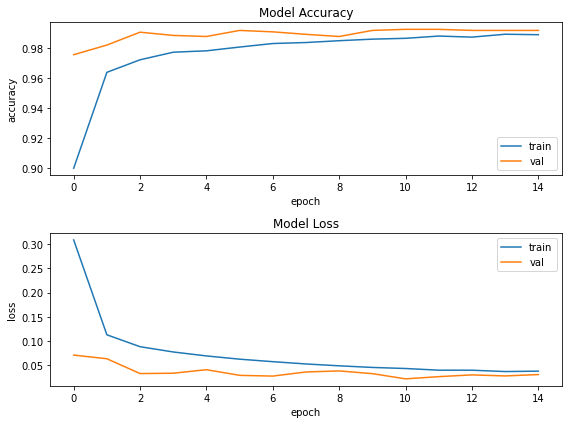

In [15]:
# evaluate the model
loss_and_metrics = model.evaluate(val_X, val_Y, verbose=2)

print("Val Loss", loss_and_metrics[0])
print("Val Accuracy", loss_and_metrics[1])

# plotting the metrics
fig = plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.tight_layout()
plt.show()

In [16]:
# predict results
submissionPredictions = model.predict(test_X)

# select the indix with the maximum probability
submissionPredictions = np.argmax(submissionPredictions,axis = 1)

submissionPredictions = pd.Series(submissionPredictions,name="Label")

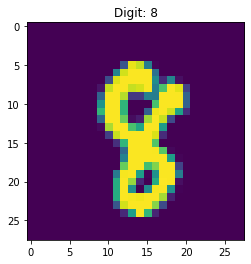

In [17]:
# testing results

itemToTest = 850
plt.imshow(test_X[itemToTest].reshape(28, 28))
# the label of the first number
plt.title(f"Digit: {submissionPredictions[itemToTest]}")
plt.show()

In [18]:
# preparing submission

submission = pd.DataFrame({'ImageId':pd.Series(list(range(1, len(submissionPredictions)+1))),
                                   'Label':pd.Series(submissionPredictions)})

submission.to_csv("submission.csv", index=False)

submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
